In [0]:
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

# Setup the training samples

Training data is Gaussian samples with a pre-defined mean and standard deviation

In [0]:
def training_sample(n_samples=128, dim=50, mean=0, std=1):
  mat = np.random.normal(loc=mean, scale=std, size=(n_samples, dim))
  mat.sort()
  return mat

In [0]:
mat = training_sample(dim=10)
print(mat[0:2, :])

[[-0.75050074 -0.72253882 -0.35760376 -0.29982809  0.23237048  0.26906279
   0.28971933  0.43138832  1.19139298  1.93532075]
 [-1.37061519 -1.04092146 -0.75376388  0.00981307  0.22052643  0.3381397
   0.34901661  0.44907991  0.94495528  1.1191419 ]]


# Setup the noise input to the generator

The noise we are using is uniform random samples from -1.0 to 1.0

In [0]:
def uniform_noise(n_samples=128, dim=50):
  mat = np.random.uniform(low=-1., high=1., size=(n_samples, dim))
  return mat

In [0]:
mat = uniform_noise()
print(mat[0:2, :])

[[-0.56946917  0.20844781 -0.18082493 -0.62380278  0.96479448 -0.20365066
   0.10410229  0.63647361 -0.90328749  0.74835686 -0.15113764  0.71952157
   0.40791592  0.31208863  0.98355927  0.2401992   0.77136015 -0.68569544
  -0.55937574 -0.17175934 -0.48929637 -0.96144658  0.52999217 -0.10633466
  -0.59422936 -0.57054272 -0.58063938 -0.18546508 -0.34491658  0.79083052
  -0.27503379 -0.17260148  0.05798013  0.5035693  -0.91520024  0.84017776
   0.88432303 -0.28952139  0.77375623  0.61841898 -0.96409122  0.65630194
   0.73581476  0.27428745 -0.90281215  0.77637039 -0.61455694 -0.16035977
   0.10259753  0.60021942]
 [ 0.96962407 -0.47929262  0.50427257 -0.08626526  0.58259596  0.79573265
  -0.09238911  0.73430327  0.43485479  0.52952049  0.12012887 -0.9115758
  -0.35792351 -0.82258417 -0.94273216  0.52080386  0.37798167  0.54233422
  -0.85103419 -0.33111009  0.31285366  0.4890387  -0.28751304  0.31322476
   0.62096418 -0.26369079 -0.25443896 -0.08053447 -0.1529356  -0.63603062
   0.7014213

# Setup the generator

The generator takes in an input matrix setup above. The model is a multi-layer network with an output dimension that is the same dimension as the training data. The final step is to sort the training data similar to how the training samples are created.


In [0]:
def make_generator(input_dim=50, output_dim=50):

  inputs = tf.keras.Input(shape=(input_dim,))
  x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(inputs)
  outputs = tf.keras.layers.Dense(output_dim, activation='linear')(x)
  #outputs = tf.sort(x, axis=-1, direction='ASCENDING', name="sort_outputs")

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [0]:
generator = make_generator()
print(generator.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1650      
Total params: 3,282
Trainable params: 3,282
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
noise = uniform_noise()
result = generator(noise, training=False)
print(result.numpy())

[[ 0.41411746  0.22913745 -0.24338296 ... -0.4135636   0.18903458
   0.00357657]
 [ 0.0893088   0.2531884   0.06489225 ... -0.5079901  -0.09333082
  -0.02859536]
 [ 0.03116179  0.07244159  0.2864731  ...  0.2757517  -0.7458199
   0.01255361]
 ...
 [-0.6955908   0.4217471  -0.00477989 ... -1.0270151   0.56408024
   0.3049831 ]
 [ 0.30069786 -0.6426348   0.16419655 ... -0.8890141   0.48763275
   0.31010646]
 [ 0.18888508  0.4096608  -0.45464355 ... -0.1222515   0.34185013
  -0.679326  ]]


# Setup the discriminator
The discriminator takes in a sample and predicts whether it is a training or testing sample.


In [0]:
def make_discriminator(input_dim=50, output_dim=1):

  inputs = tf.keras.Input(shape=(input_dim,))
  x = tf.keras.layers.Dense(16, activation=tf.nn.relu)(inputs)
  outputs = tf.keras.layers.Dense(output_dim, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [0]:
discriminator = make_discriminator()
print(discriminator.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
generated_sample = generator(uniform_noise(n_samples=5))
result = discriminator(generated_sample)
print(result)

tf.Tensor(
[[0.696931  ]
 [0.45723337]
 [0.6949912 ]
 [0.6294236 ]
 [0.7148362 ]], shape=(5, 1), dtype=float32)


# Setup the loss and optimizer
We setup two optimizers, one for the generator, one for the discriminator. These are taken from https://www.tensorflow.org/tutorials/generative/dcgan

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(5e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-3)

# Setup the training

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator, discriminator, mean=0., std=1.):
  noise = tf.random.uniform((128, 50), minval=-1., maxval=1.)
  train_sample = tf.random.normal(
    (128, 50),
    mean=mean,
    stddev=std,
  )
  train_sample = tf.sort(train_sample, axis=-1, direction='ASCENDING')

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_samples = generator(noise, training=True)

    real_output = discriminator(train_sample, training=True)
    fake_output = discriminator(generated_samples, training=True)

    gen_loss = 4*generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [0]:
def train(num_epochs=1000, num_batches=100, mean=1., std=3.):
  generator = make_generator()
  discriminator = make_discriminator()
  gens = []
  discs = []
  for epoch in range(1, num_epochs+1):
    for batch in range(num_batches):
      gen_loss, disc_loss = train_step(generator, discriminator, mean=mean, std=std)
    eval_sample = tf.random.uniform((1, 50), minval=-1., maxval=1.)
    result = generator(eval_sample)
    gen = gen_loss.numpy().mean()
    disc = disc_loss.numpy().mean()
    gens.append(gen)
    discs.append(disc)
    print(f'On epoch {epoch} the generator loss is {gen:.2f}, the discriminator loss is {disc:.2f}')
  return gens, discs, generator, discriminator

In [0]:
gens, discs, generator, discriminator = train()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
On epoch 1 the generator loss is 2.76, the discriminator loss is 1.01
On epoch 2 the generator loss is 2.59, the discriminator loss is 1.07
On epoch 3 the generator loss is 2.18, the discriminator loss is 1.24
On epoch 4 the generator loss is 2.77, the discriminator loss is 1.01
On epoch 5 the generator loss is 2.77, the discriminator loss is 1.01
On epoch 6 the generator loss is 2.77, the discriminator loss is 1.01
On epoch 7 the generator loss is 2.14, the discriminator loss is 1.28
On epoch 8 the generator loss is 2.23, the discriminator loss is 1.24
On epoch 9 the generator loss is 2.14, the discriminator loss is 1.34
On epoch 10 the generator loss is 2.53, the discriminator loss is 1.10
On epoch 11 the generator loss is 2.77, the discriminator loss is 1.01
On epoch 12 the generator loss is 2.77, the discriminator loss is 1.01
On epoch 13 the generator loss is 2.77, the discriminator loss 

In [0]:
noise = tf.random.uniform((10, 50), minval=-1., maxval=1.)
generated_samples = generator(noise, training=False)
fake_output = discriminator(generated_samples, training=False)
print(fake_output.numpy())

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [0]:
train_sample = tf.random.normal(
    (10, 50),
    mean=1,
    stddev=3,
  )
train_sample = tf.sort(train_sample, axis=-1, direction='ASCENDING')
real_output = discriminator(train_sample, training=False)
print(real_output.numpy())

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


2.9387653 13.853054


(array([3., 6., 7., 7., 7., 2., 7., 5., 0., 6.]),
 array([-20.348656 , -15.358021 , -10.367385 ,  -5.37675  ,  -0.3861145,
          4.604521 ,   9.595156 ,  14.585792 ,  19.576427 ,  24.567062 ,
         29.557697 ], dtype=float32),
 <a list of 10 Patch objects>)

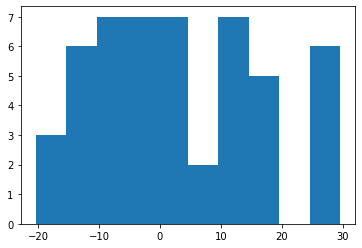

In [0]:
noise = tf.random.uniform((1, 50), minval=-1., maxval=1.)
generated_sample = generator(noise).numpy().ravel()
print(generated_sample.mean(), generated_sample.std())
plt.hist(generated_sample)

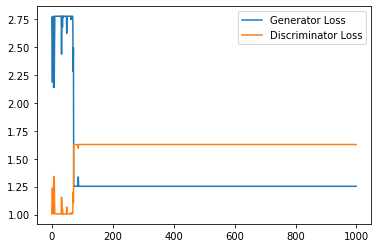

In [0]:
plt.plot(range(len(gens)), gens, range(len(discs)), discs)
plt.legend(['Generator Loss', 'Discriminator Loss'])